In [1]:
#various imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib as mpl

In [2]:
## what do I want to show?
# lets discover if ML can determine if a sale took place in a variety of different wards
#use ML to project increases over time?

In [3]:
#import housing data
TokyoHousing=pd.read_excel('13_Tokyo_20053_20212_e.xlsx')

#show head
TokyoHousing.head()

,No,Type,Region,"City,Town,Ward,Village code",Prefecture,"City,Town,Ward,Village",Area,Nearest stationFName,Nearest stationFDistance(minute),Transaction-price(total),...,Purpose of Use,Frontage roadFDirection,Frontage roadFClassification,Frontage roadFBreadth(m),City Planning,Maximus Building Coverage Ratio(%),Maximus Floor-area Ratio(%),Transaction period,Renovation,Transactional factors
0,1,"Pre-owned Condominiums, etc.",NaN,13101,Tokyo,Chiyoda Ward,Iidabashi,Iidabashi,5,59000000,...,House,NaN,NaN,NaN,Commercial Zone,80.0,500.0,4th quarter 2020,Not yet,NaN
1,2,"Pre-owned Condominiums, etc.",NaN,13101,Tokyo,Chiyoda Ward,Iidabashi,Iidabashi,5,23000000,...,House,NaN,NaN,NaN,Commercial Zone,80.0,500.0,4th quarter 2020,Not yet,NaN
2,3,"Pre-owned Condominiums, etc.",NaN,13101,Tokyo,Chiyoda Ward,Iidabashi,Iidabashi,5,26000000,...,House,NaN,NaN,NaN,Commercial Zone,80.0,500.0,4th quarter 2020,Done,NaN
3,4,"Pre-owned Condominiums, etc.",NaN,13101,Tokyo,Chiyoda Ward,Iidabashi,Iidabashi,4,88000000,...,House,NaN,NaN,NaN,Commercial Zone,80.0,500.0,3rd quarter 2020,Not yet,NaN
4,5,"Pre-owned Condominiums, etc.",NaN,13101,Tokyo,Chiyoda Ward,Iidabashi,Iidabashi,3,58000000,...,House,NaN,NaN,NaN,Commercial Zone,80.0,700.0,2nd quarter 2020,NaN,NaN


In [4]:
#pull condo data, take only he data we want, rename variables to be easier
condo=TokyoHousing[TokyoHousing['Type']=='Pre-owned Condominiums, etc.']
condo=condo[['City,Town,Ward,Village', 'Area', 'Nearest station：Name','Nearest station：Distance(minute)','Area(m^2)','Transaction-price(total)','Transaction period',
             'Year of construction','Renovation']]
condo.rename(columns={'City,Town,Ward,Village':'City','Nearest station：Name':'Nearest station','Nearest station：Distance(minute)':'Nearest station in minute', 'Area(m^2)':'Space in m*m','Transaction-price(total)':'Price'}, inplace=True)

In [5]:
#drop NA data, chec
df=condo.dropna()

# Convert Renovation:Done to yes, Not yet and -- to No
df['Renovation']=df['Renovation'].apply(lambda item: 'Yes'if item==1 else 0)

#remove invalid dates
df=df[df['Year of construction']!='--']
df=df[df['Year of construction']!='before the war']
df['Year of construction'].unique()

<ipython-input-5-db0cd6a86230>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Renovation']=df['Renovation'].apply(lambda item: 'Yes'if item==1 else 0)


array([2007, 2003, 1984, 2013, 1985, 1982, 2012, 1999, 1998, 1997, 2004,
       2001, 2010, 2019, 2018, 1986, 1977, 1976, 2011, 1970, 1972, 1979,
       2002, 2006, 2005, 2008, 2000, 2016, 2015, 2014, 2009, 1978, 1981,
       1980, 1975, 2017, 1983, 1992, 1971, 1969, 1996, 1991, 1988, 1973,
       1989, 1974, 1993, 2020, 1994, 1995, 2021, 1990, 1987, 1964, 1953,
       1959, 1960, 1966, 1968, 1949, 1965, 1967, 1950, 1963, 1962, 1954,
       1961, 1956, 1958, 1947, 1946], dtype=object)

In [6]:
#can replace transaction prd, not a daytime idex
yearqtr=df['Transaction period'].str.replace(r'(\d).. quarter (\d+)', r'\2-Q\1')

#convert Trans Prd to quarters
df['Transaction period']=pd.PeriodIndex(yearqtr, freq='Q')

#non-number characters for getting to the nearest station are removed from df
df=df[df['Nearest station in minute']!='--']
df=df[df['Nearest station in minute']!='30-60minutes']
df=df[df['Nearest station in minute']!='1H-1H30']
df=df[df['Nearest station in minute']!='1H30-2H']
df=df[df['Nearest station in minute']!='2H-']

#remove weird pricing ranges
df=df[(df['Price']>=5000000) & (df['Price']<=150000000)]
df

#edit costs to be in millions yen
df["Price"]=df["Price"]/1000000

#remove suspiciously large areas

df=df[df['Space in m*m']<=100]

In [7]:
#double check info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 173448 entries, 0 to 467350
Data columns (total 9 columns):
 #   Column                     Non-Null Count   Dtype        
---  ------                     --------------   -----        
 0   City                       173448 non-null  object       
 1   Area                       173448 non-null  object       
 2   Nearest station            173448 non-null  object       
 3   Nearest station in minute  173448 non-null  object       
 4   Space in m*m               173448 non-null  object       
 5   Price                      173448 non-null  float64      
 6   Transaction period         173448 non-null  period[Q-DEC]
 7   Year of construction       173448 non-null  object       
 8   Renovation                 173448 non-null  int64        
dtypes: float64(1), int64(1), object(6), period[Q-DEC](1)
memory usage: 13.2+ MB


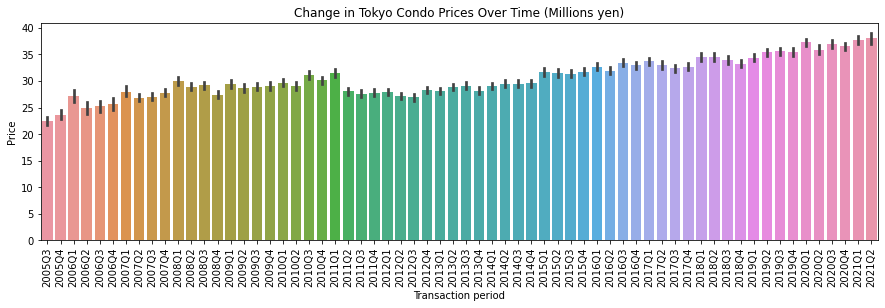

In [8]:
#Overall trend in prices, create df2 to sort by date
df2=df.copy()
df2=df2.set_index('Transaction period')
df2=df2.sort_index()
plt.figure(figsize=(15,4))
plt.xticks(rotation=90);
sns.barplot(x=df2.index, y='Price', data=df2).set_title('Change in Tokyo Condo Prices Over Time (Millions yen)')
plt.savefig('overall.png', bbox_inches='tight')

In [9]:
#get relevant data for the wards
bunkyo_data=df[df['City'] == 'Bunkyo Ward']
itabashi_data=df[df['City'] == 'Itabashi Ward']
shinjuku_data=df[df['City'] == 'Shinjuku Ward']
hachioji_data=df[df['City'] == 'Hachioji City']

In [10]:
# clean the data
shinjuku_data=shinjuku_data[shinjuku_data['Space in m*m']<=100]

itabashi_data=itabashi_data[itabashi_data['Space in m*m']<=100]

bunkyo_data=bunkyo_data[bunkyo_data['Space in m*m']<=100]

hachioji_data=hachioji_data[hachioji_data['Space in m*m']<=100]

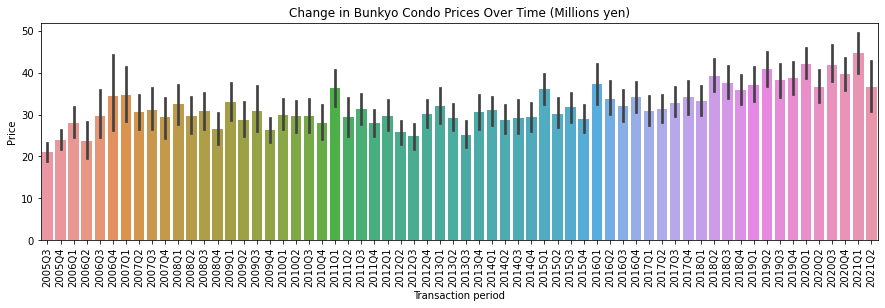

In [11]:
#change the index and sort for easier reading when graphed
bunkyo_data=bunkyo_data.set_index('Transaction period')
bunkyo_data=bunkyo_data.sort_index()
#bunkyo graph
plt.figure(figsize=(15,4))
plt.xticks(rotation=90);
sns.barplot(x=bunkyo_data.index, y='Price', data=bunkyo_data).set_title('Change in Bunkyo Condo Prices Over Time (Millions yen)')
plt.ticklabel_format(style='plain', axis='y')
plt.savefig('bunkyo.png', bbox_inches='tight')

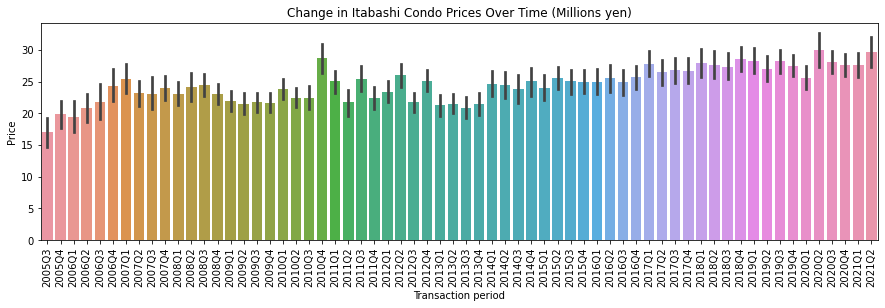

In [12]:
#same for Itabashi
itabashi_data=itabashi_data.set_index('Transaction period')
itabashi_data=itabashi_data.sort_index()
plt.figure(figsize=(15,4))
plt.xticks(rotation=90);
sns.barplot(x=itabashi_data.index, y='Price', data=itabashi_data).set_title('Change in Itabashi Condo Prices Over Time (Millions yen)')
plt.ticklabel_format(style='plain', axis='y')

plt.savefig('itabashi.png', bbox_inches='tight')

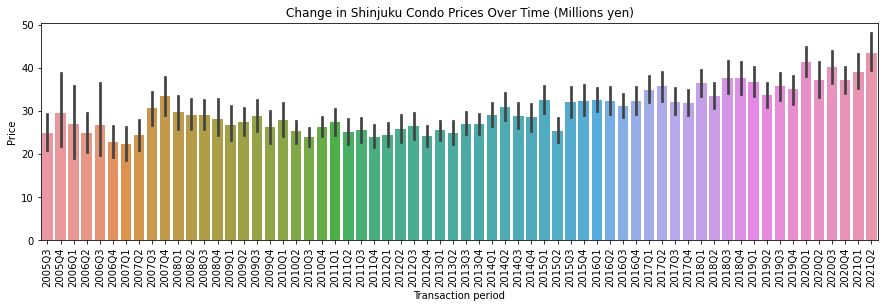

In [13]:
#for Shinjuku
shinjuku_data=shinjuku_data.set_index('Transaction period')
shinjuku_data=shinjuku_data.sort_index()
plt.figure(figsize=(15,4))
plt.xticks(rotation=90);
tst= sns.barplot(x=shinjuku_data.index, y='Price', data=shinjuku_data).set_title('Change in Shinjuku Condo Prices Over Time (Millions yen)')
plt.ticklabel_format(style='plain', axis='y')
plt.savefig('Shinjuku.png', bbox_inches='tight')

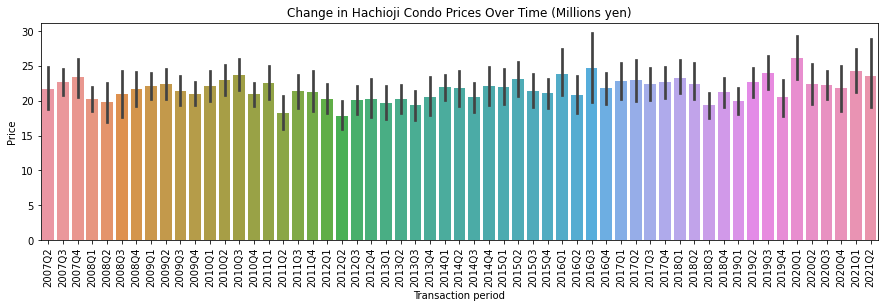

In [14]:
#Finally, for Hachioji
hachioji_data=hachioji_data.set_index('Transaction period')
hachioji_data=hachioji_data.sort_index()
plt.figure(figsize=(15,4))
plt.xticks(rotation=90);
tst= sns.barplot(x=hachioji_data.index, y='Price', data=hachioji_data).set_title('Change in Hachioji Condo Prices Over Time (Millions yen)')
plt.ticklabel_format(style='plain', axis='y')
plt.savefig('Hachioji.png', bbox_inches='tight')

In [15]:
#From this point we return to main dataframe before making a new "combined" dataframe

#then convert to datetime
df['Transaction period']=pd.to_datetime(df['Transaction period'].dt.strftime('%Y-%m'))

In [16]:
#create dataframe of only the desired prefectures
combined=[df[df['City'] == 'Bunkyo Ward'],df[df['City'] == 'Itabashi Ward'],df[df['City'] == 'Shinjuku Ward'], df[df['City'] == 'Hachioji City']]
combined_data=pd.concat(combined)

#drop area and nearest station
combined_data=combined_data.drop('Area', axis=1)
combined_data=combined_data.drop('Nearest station', axis=1)

#randomize the data
combined_data = combined_data.sample(frac=1).reset_index(drop=True)

combined_data.head()

,City,Nearest station in minute,Space in m*m,Price,Transaction period,Year of construction,Renovation
0,Bunkyo Ward,4,20,22.0,2015-06-01,2004,0
1,Bunkyo Ward,6,20,17.0,2017-03-01,2010,0
2,Itabashi Ward,6,25,9.0,2007-06-01,1990,0
3,Hachioji City,13,45,10.0,2013-06-01,1997,0
4,Shinjuku Ward,4,25,42.0,2019-12-01,2006,0


In [17]:
combined_data=combined_data.astype({'Nearest station in minute':'int','Space in m*m':'int','Year of construction':'int'})
grouped = combined_data.groupby('City')
#grouped[['Nearest station in minute','Space in m*m','Price','Year of construction']].mean()
grouped[['Nearest station in minute','Space in m*m','Price','Year of construction']].mean().sort_values(['Price'])

,Nearest station in minute,Space in m*m,Price,Year of construction
City,,,,
Hachioji City,10.574226,68.080070,21.750994,1996.550263
Itabashi Ward,7.291731,47.489759,24.990617,1996.515873
Shinjuku Ward,5.169845,36.237315,30.976436,1996.962418
Bunkyo Ward,5.393679,39.066689,32.775410,1998.261791


In [18]:
#check data
combined_data.head()

,City,Nearest station in minute,Space in m*m,Price,Transaction period,Year of construction,Renovation
0,Bunkyo Ward,4,20,22.0,2015-06-01,2004,0
1,Bunkyo Ward,6,20,17.0,2017-03-01,2010,0
2,Itabashi Ward,6,25,9.0,2007-06-01,1990,0
3,Hachioji City,13,45,10.0,2013-06-01,1997,0
4,Shinjuku Ward,4,25,42.0,2019-12-01,2006,0


In [19]:
#set Transaction period as index, but remove days
combined_data=combined_data.set_index('Transaction period')
combined_data.index=combined_data.index.strftime('%Y.%m')

In [20]:
#convert non-integer data to integer
#combined_data=combined_data.astype('int')

In [21]:
#now add Transact prd back as a col
combined_data.reset_index(inplace=True)

In [22]:
#Check data
combined_data

,Transaction period,City,Nearest station in minute,Space in m*m,Price,Year of construction,Renovation
0,2015.06,Bunkyo Ward,4,20,22.0,2004,0
1,2017.03,Bunkyo Ward,6,20,17.0,2010,0
2,2007.06,Itabashi Ward,6,25,9.0,1990,0
3,2013.06,Hachioji City,13,45,10.0,1997,0
4,2019.12,Shinjuku Ward,4,25,42.0,2006,0
...,...,...,...,...,...,...,...
26239,2008.09,Itabashi Ward,10,20,22.0,2007,0
26240,2015.09,Bunkyo Ward,5,15,17.0,2001,0
26241,2015.12,Shinjuku Ward,3,40,32.0,2004,0
26242,2017.06,Itabashi Ward,12,55,26.0,2000,0


In [23]:
#set Transact Prd to float, this is for ML later
combined_data['Transaction period']=combined_data['Transaction period'].astype('float')

In [24]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26244 entries, 0 to 26243
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Transaction period         26244 non-null  float64
 1   City                       26244 non-null  object 
 2   Nearest station in minute  26244 non-null  int32  
 3   Space in m*m               26244 non-null  int32  
 4   Price                      26244 non-null  float64
 5   Year of construction       26244 non-null  int32  
 6   Renovation                 26244 non-null  int64  
dtypes: float64(2), int32(3), int64(1), object(1)
memory usage: 1.1+ MB


C:\Users\Phill\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Phill\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Phill\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Phill\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


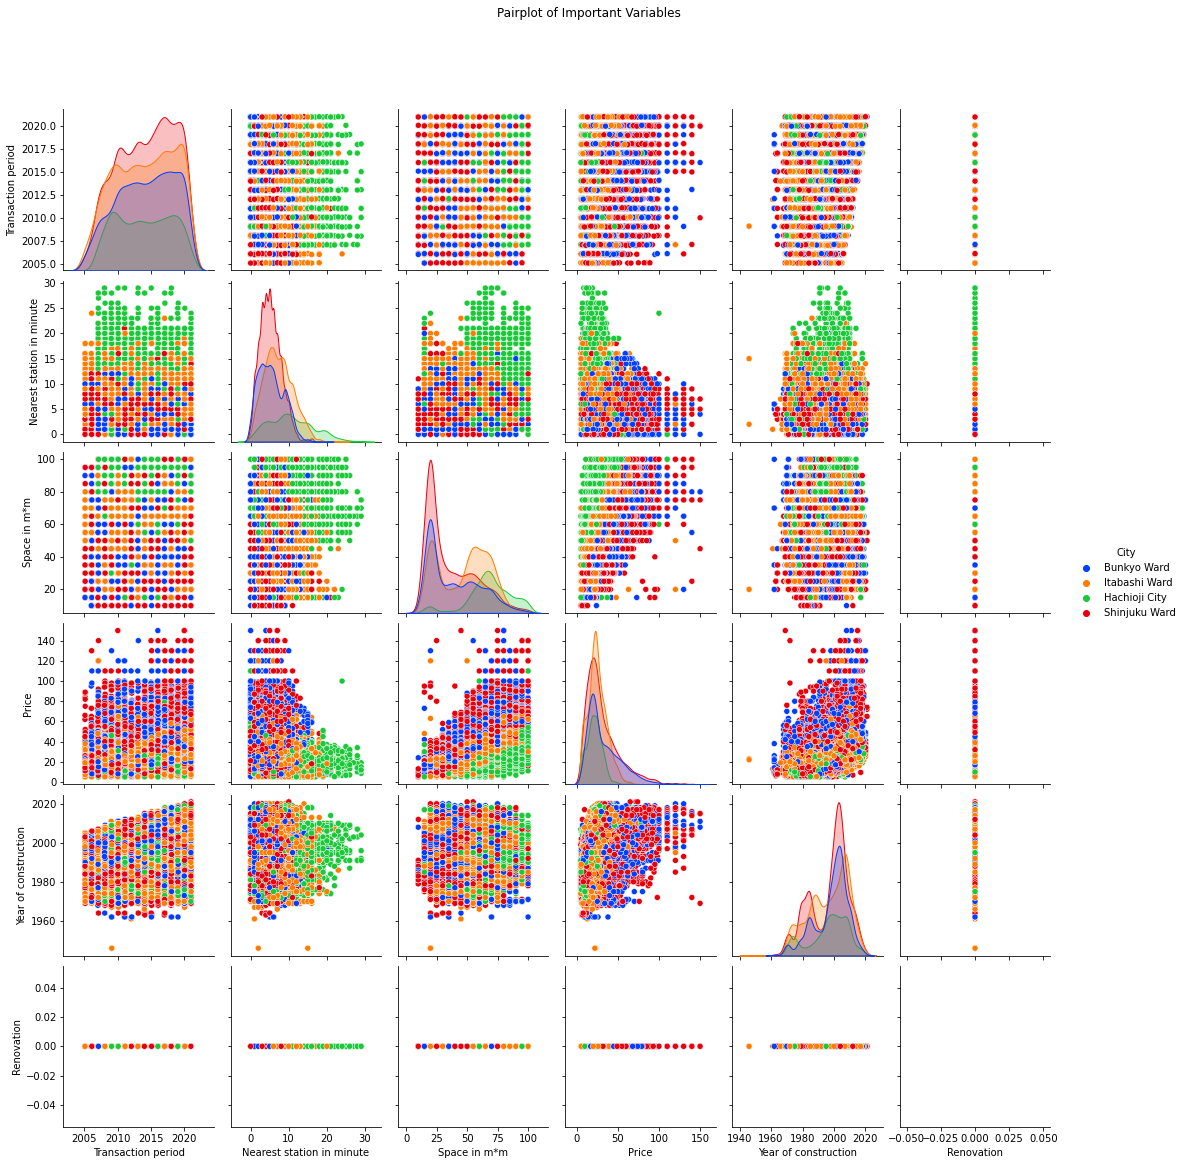

In [25]:
#show the differences between the four cities via graphing utility
g=sns.pairplot(combined_data, hue='City', palette='bright')
g.fig.suptitle('Pairplot of Important Variables', y=1.08)
plt.savefig('pairplotBAD.png', bbox_inches='tight')

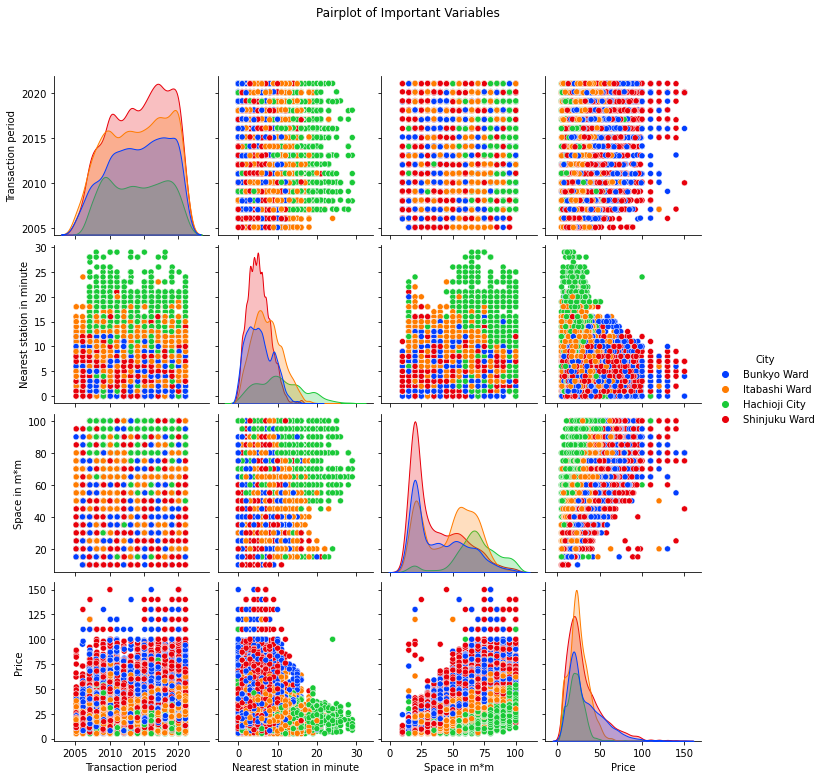

In [26]:
#graphs show Rennovation and Build year are unimportant, lets drop those
combined_data=combined_data.drop("Renovation", axis=1)
combined_data=combined_data.drop("Year of construction", axis=1)
#plot again
g=sns.pairplot(combined_data, hue='City', palette='bright')
g.fig.suptitle('Pairplot of Important Variables', y=1.08)
plt.savefig('pairplotGOOD.png', bbox_inches='tight')

In [27]:
#now lets change city names to be numbers
combined_data["City"].replace({"Bunkyo Ward": 1, "Itabashi Ward": 2, "Shinjuku Ward": 3, "Hachioji City": 4}, inplace=True) 
#bunkyo=1, itabashi=2, shinjuku=3, hachioji 4

In [28]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26244 entries, 0 to 26243
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Transaction period         26244 non-null  float64
 1   City                       26244 non-null  int64  
 2   Nearest station in minute  26244 non-null  int32  
 3   Space in m*m               26244 non-null  int32  
 4   Price                      26244 non-null  float64
dtypes: float64(2), int32(2), int64(1)
memory usage: 820.2 KB


In [83]:
combined_data

,Transaction period,City,Nearest station in minute,Space in m*m,Price
0,2015.06,1,4,20,22.0
1,2017.03,1,6,20,17.0
2,2007.06,2,6,25,9.0
3,2013.06,4,13,45,10.0
4,2019.12,3,4,25,42.0
...,...,...,...,...,...
26239,2008.09,2,10,20,22.0
26240,2015.09,1,5,15,17.0
26241,2015.12,3,3,40,32.0
26242,2017.06,2,12,55,26.0


In [110]:
#import a bunch of ML utilities
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import NearestCentroid
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [111]:
#pull all data into test sets
test_X_data=combined_data.drop("City", axis=1)
test_y_data=combined_data["City"]
Xtrain, Xtest, ytrain, ytest=train_test_split(test_X_data, test_y_data, random_state=0, train_size=0.7)


In [112]:
#supervised learning

In [113]:
#NearestCentroid - fail
model = NearestCentroid()
model.fit(Xtrain, ytrain)
model.predict(Xtest)
y_model=model.predict(Xtest)
accuracy_score(ytest, y_model)

0.4497078994157988

In [114]:
#Gaussian - fail
model=GaussianNB()
model.fit(Xtrain, ytrain)
y_model=model.predict(Xtest)
accuracy_score(ytest, y_model)

0.5006350012700025

In [115]:
#K-Neighbors - fail
model=KNeighborsClassifier(n_neighbors=1)
model.fit(Xtrain, ytrain)
y_model=model.predict(Xtest)
accuracy_score(ytest, y_model)

0.5511811023622047

In [116]:
#unsupervised learning

In [163]:
#Linear regression work VERY well for determining the differences between Tokyo wards, 
#the previous iteration forgot to include the city as an element and was trying to determin 
#if price could be identified by all other elements
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
#start by creating X and Y array
X = combined_data[['Transaction period', 'Nearest station in minute', 'Space in m*m', 'Price']]
y = combined_data['City']

#test and train data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=101)

#inst Lin reg
lm = LinearRegression()
lm.fit(X_train,y_train)

LinearRegression()

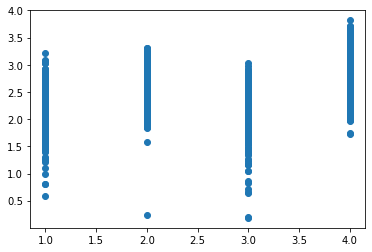

In [164]:
#eval, looking...good?
predictions = lm.predict(X_test)
plt.scatter(y_test, predictions)

In [165]:
showcase=pd.DataFrame(y_test, columns=['City'])
showcase

,City
14658,2
20547,4
3916,2
15749,2
14003,1
...,...
8870,3
18683,4
1773,2
4389,2


MAE: 0.8443975851574315
MSE: 0.8391237833481864
RMSE: 0.9160369988969803


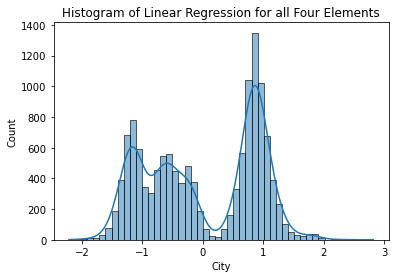

In [166]:
#lin reg metrics, very high numbers
from sklearn import metrics
sns.histplot((y_test-predictions), bins=50, kde=True).set_title('Histogram of Linear Regression for all Four Elements')
plt.savefig('Everyone.png', bbox_inches='tight')
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

In [167]:
#I'm unsure why, but we have re reorder the index
#namely, the index information is all wrong, with predicitions being sequential
#however, city indexes appear to have been maintained? this is shown by "showcase"
predictions = lm.predict(X_test)
test=pd.DataFrame(y_test, columns=['City'])
test.reset_index(inplace=True,drop=True)
test['predictions']=pd.DataFrame(predictions)
print(test['City'].mean()-test['predictions'].mean())
test

-0.002682950151247976


,City,predictions
0,2,2.677446
1,4,2.768419
2,2,2.364384
3,2,2.201180
4,1,2.382535
...,...,...
13117,3,2.331490
13118,4,3.162070
13119,2,2.571942
13120,2,2.218431


In [134]:
#log regression, lets use only bunkyo and itabashi this time
combined_data.info()
combined2=[combined_data[combined_data['City'] == 1],combined_data[combined_data['City'] == 2]]
combined2=pd.concat(combined2)
combined2.info()
from sklearn.linear_model import LogisticRegression

#reload the data
X_train, X_test, y_train, y_test = train_test_split(combined2.drop("City", axis=1), combined2['City'], test_size=0.4, random_state=101)

#test the log model
logmodel = LogisticRegression(max_iter=3000)   # Without max_iter=1500 it will cause a warning.
logmodel.fit(X_train, y_train)
predictions = logmodel.predict(X_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26244 entries, 0 to 26243
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Transaction period         26244 non-null  float64
 1   City                       26244 non-null  int64  
 2   Nearest station in minute  26244 non-null  int32  
 3   Space in m*m               26244 non-null  int32  
 4   Price                      26244 non-null  float64
dtypes: float64(2), int32(2), int64(1)
memory usage: 820.2 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 13855 entries, 0 to 26243
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Transaction period         13855 non-null  float64
 1   City                       13855 non-null  int64  
 2   Nearest station in minute  13855 non-null  int32  
 3   Space in m*m               13855 non-null  in

In [135]:
#log reg metrics
#the issue here lies in that I do not know how to fix the #2 precision/recall/f1-score part, they are all listed as 0
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print("Class report:\n"+classification_report(y_test, predictions)+"\n")
print(confusion_matrix(y_test, predictions))
cm=confusion_matrix(y_test, predictions)
tp, fn, fp, tn =cm.flatten()
tp, fn, fp, tn

#0
Precision0=tp/(tp+fp); print(Precision0)
Recall0=tp/(tp+fn)   ; print(Recall0)
F_1_0=2*Precision0*Recall0/(Precision0+Recall0) ;print(F_1_0)
print(149+14) # Support

#1
Precision1=tn/(tn+fn); print(Precision1)
Recall1=tn/(tn+fp)   ; print(Recall1)
F_1_1=2*Precision1*Recall1/(Precision1+Recall1) ;print(F_1_1)
print(33+71) # Support

Class report:
              precision    recall  f1-score   support

           1       0.68      0.70      0.69      2403
           2       0.76      0.75      0.76      3139

    accuracy                           0.73      5542
   macro avg       0.72      0.72      0.72      5542
weighted avg       0.73      0.73      0.73      5542


[[1682  721]
 [ 792 2347]]
0.6798706548100243
0.6999583853516438
0.6897683001845396
163
0.7649934810951761
0.7476903472443454
0.7562429515063639
104


In [136]:
#accuracy
Total=tp+tn+fp+fn
Accuracy=(tp+tn)/Total
print(Accuracy)
print(Total) # Support

0.7269938650306749
5542


In [137]:
accuracy_score(y_test, predictions)

0.7269938650306749

In [162]:
#log regression predicition check, again, we have to rest the index for some reaosn
predictions = lm.predict(X_test)
test=pd.DataFrame(y_test, columns=['City'])
test.reset_index(inplace=True,drop=True)
test['predictions']=pd.DataFrame(predictions)
print(test['City'].mean()-test['predictions'].mean())
test
#for some reason, if we put this before the regression metrics it causes an error

0.016690463085697882


,City,predictions
0,4,4.041057
1,1,1.924415
2,1,1.034743
3,1,-0.098251
4,4,3.438533
...,...,...
4728,1,1.176838
4729,4,3.427559
4730,4,3.689292
4731,4,3.569632


In [139]:
#that isn't very accurate! What if we compare from Bunkyo to a place outside the 23 wards? Like hachioji?

In [140]:
combined=[combined_data[combined_data['City'] == 1],combined_data[combined_data['City'] == 4]]
combined3=pd.concat(combined)
combined3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9465 entries, 0 to 26238
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Transaction period         9465 non-null   float64
 1   City                       9465 non-null   int64  
 2   Nearest station in minute  9465 non-null   int32  
 3   Space in m*m               9465 non-null   int32  
 4   Price                      9465 non-null   float64
dtypes: float64(2), int32(2), int64(1)
memory usage: 369.7 KB


In [141]:
#randomize the data
combined3 = combined3.sample(frac=1).reset_index(drop=True)

In [142]:
len(combined3[combined3["City"]==1])

6043

In [143]:
#log regression again, Hachioji and Bunkyo
#same as previous log regression
#reload the data
X_train, X_test, y_train, y_test = train_test_split(combined3.drop("City", axis=1), combined3['City'], test_size=0.5, random_state=101)

#test the log model
logmodel = LogisticRegression(max_iter=8000)   # Without max_iter=1500 it will cause a warning.
logmodel.fit(X_train, y_train)
predictions = logmodel.predict(X_test)

#log reg metrics
print("Class report:\n"+classification_report(y_test, predictions)+"\n")
print(confusion_matrix(y_test, predictions))
cm=confusion_matrix(y_test, predictions)
tp, fn, fp, tn =cm.flatten()
tp, fn, fp, tn

#1
Precision0=tp/(tp+fp)
print(Precision0)
Recall0=tp/(tp+fn)
print(Recall0)
F_1_0=2*Precision0*Recall0/(Precision0+Recall0)
print(F_1_0)

#4
Precision1=tn/(tn+fn)
print(Precision1)
Recall1=tn/(tn+fp)
print(Recall1)
F_1_1=2*Precision1*Recall1/(Precision1+Recall1)
print(F_1_1)

#Accuracy
Total=tp+tn+fp+fn
Accuracy=(tp+tn)/Total
print(Accuracy)
print(Total)
accuracy_score(y_test, predictions)

Class report:
              precision    recall  f1-score   support

           1       0.94      0.97      0.96      2992
           4       0.94      0.90      0.92      1741

    accuracy                           0.94      4733
   macro avg       0.94      0.93      0.94      4733
weighted avg       0.94      0.94      0.94      4733


[[2892  100]
 [ 169 1572]]
0.9447892845475335
0.9665775401069518
0.9555592268296713
0.9401913875598086
0.9029293509477312
0.9211837093466159
0.9431650116205367
4733


0.9431650116205367

In [144]:
#log regression predicition check, again, we have to rest the index for some reason
predictions = lm.predict(X_test)
test=pd.DataFrame(y_test, columns=['City'])
test.reset_index(inplace=True,drop=True)
test['predictions']=pd.DataFrame(predictions)
test

,City,predictions
0,4,3.299526
1,1,2.368499
2,1,2.121577
3,1,1.592925
4,4,2.875927
...,...,...
4728,1,2.140148
4729,4,2.873154
4730,4,3.007760
4731,4,2.997434


In [49]:
#We do get much better results comparing only two areas as opposed to three. 
#Lets break things down a little better, using only Bunkyo and Hachioji this time
combined3

,Transaction period,City,Nearest station in minute,Space in m*m,Price
0,2017.12,1,0,55,83.0
1,2015.03,1,12,55,27.0
2,2013.09,1,3,40,30.0
3,2019.12,1,3,40,44.0
4,2018.12,4,1,70,16.0
...,...,...,...,...,...
9460,2008.06,4,4,45,6.7
9461,2012.12,4,16,55,8.3
9462,2009.03,1,7,35,26.0
9463,2009.03,4,8,95,38.0


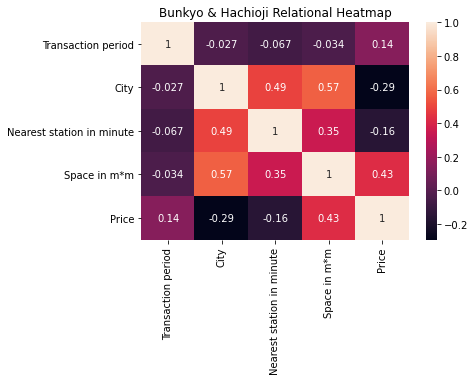

In [145]:
#combined3 has everything we need right now, so lets look at a heatmap
sns.heatmap(combined3.corr(), annot=True).set_title('Bunkyo & Hachioji Relational Heatmap')
plt.savefig('BKHOJHeatmap.png', bbox_inches='tight')

In [146]:
#price and space seem quite related, but even more interesting, 
#City and minutes to nearest station are quite strongly related

In [147]:
#When using supervised, K-Heighbors does very well at 50% test data
#pull all data into test sets
test_X_data=combined3.drop("City", axis=1)
test_y_data=combined3["City"]
Xtrain, Xtest, ytrain, ytest=train_test_split(test_X_data, test_y_data, random_state=0, train_size=0.5)

#K-Neighbors - Success
model=KNeighborsClassifier(n_neighbors=1)
model.fit(Xtrain, ytrain)
y_model=model.predict(Xtest)
accuracy_score(ytest, y_model)

0.9433762941052187

MAE: 0.5829774586443185
MSE: 0.6462199030333755
RMSE: 0.8038780398999438
8266    4
1859    1
2267    1
8609    1
2439    4
       ..
4250    1
4450    4
1064    4
7375    4
9015    4
Name: City, Length: 4733, dtype: int64


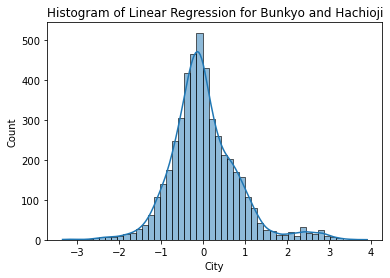

In [151]:
#with unsupervised, we have no problems. The previous lesson I was using a Y of "Price" instead of "City"
#When fixing this we see that the unsupevised Linear regression model is able to determine everything almost perfectly
#Linear regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
#start by creating X and Y array
X = combined3[['Transaction period', 'Nearest station in minute', 'Space in m*m', "Price"]]
y = combined3['City']

#test and train data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=101)

#inst Lin reg
lm = LinearRegression()
lm.fit(X_train,y_train)

#eval, not looking so great
predictions = lm.predict(X_test)
#plt.scatter(y_test, predictions)
sns.histplot((y_test-predictions), bins=50, kde=True).set_title('Histogram of Linear Regression for Bunkyo and Hachioji')
plt.savefig('BQHOJhistogram.png', bbox_inches='tight')

#lin reg metrics, very high numbers
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

In [160]:
#again, we reset the index
test2=y_test.to_frame()
test2.reset_index(inplace=True,drop=True)
test2['predictions']=pd.DataFrame(predictions)
print(test2['City'].mean()-test2['predictions'].mean())
test2

0.016690463085697882


,City,predictions
0,4,4.041057
1,1,1.924415
2,1,1.034743
3,1,-0.098251
4,4,3.438533
...,...,...
4728,1,1.176838
4729,4,3.427559
4730,4,3.689292
4731,4,3.569632
